# A metodologia se inicia com a leitura dos arquivos dicom do dataset cq500

imports necessários para fazer o código executar 

Essas importações utilizam bibliotecas já consagradas na comunidade, desde manipuladores de arquivos até manipuladores de exames médicos no formato dicom

há tambem as API necessárias para o treinamento da rede neural profunda, nesta ocasião mais especificamente pytorch. Uma API específica para manipulação de tensor, treinamento de algoritmos de inteligência artificial voltado para a linguagem de programação python.

In [4]:
import argparse
import os
import pydicom
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
import torch.nn.init
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import scipy.ndimage
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import scipy.ndimage as ndimage

!pip install optuna
import optuna
import cufflinks
import plotly
import matplotlib as plot


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#responsável por realizar a exibição de imagens no ambiente jupyter nobebook
%matplotlib inline


# realizando a verificação da utilização da gpu para treino da rede neural

In [3]:
use_cuda = torch.cuda.is_available()
print('A gpu será utilizada para treinamento: ' + str(use_cuda))

A gpu será utilizada para treinamento: True


In [4]:
# código adicionado para impedir de dar erro no parser dos argumentos necessários para rodar a rede
import sys
sys.argv=['']
del sys

# Argumentos necessários para que a rede possa executar

Este argumentos estão descritos no artigo original como experimentos, contudo não há uma formulação matemática do processo de otimização aplicado para tais resultados e possíveis argumentos. O artigo cita apenas que houve avaliação comparando os resultados obtidos da proposta com um ground thruth.

### nChannel = 100 - Quantidade de neuronios usados nas camadas da deep learning de segmentação.
### maxIter = 50 - Quantidade de iterações de treinamento.
### minLabels = 3 - Quantidade mínima de segmentos/regiões que a rede deverá criar para cada imagem.
### lr = 0.1 - Taxa de aprendizado utilizado na deep learning.
### nConv = 3 - Quantidade de camadas convolucionais no terceiro bloco da deep learning.
### visualize - Responsável por exibir imagens durante a execução do treinamento
### stepsize_sim = 1 - Tamanho do passo na loss de similaridade
### stepsize_con = 1 - Tamanho do passo na loss de continuidade

In [5]:
parser = argparse.ArgumentParser(description='PyTorch Unsupervised Segmentation')
# parser.add_argument('--scribble', action='store_true', default=False, help='use scribbles')
parser.add_argument('--nChannel', metavar='N', default=100, type=int, help='number of channels')
parser.add_argument('--maxIter', metavar='T', default=50, type=int, help='number of maximum iterations')
parser.add_argument('--minLabels', metavar='minL', default=3, type=int, help='minimum number of labels')
parser.add_argument('--lr', metavar='LR', default=0.1, type=float, help='learning rate')
parser.add_argument('--nConv', metavar='M', default=3, type=int, help='number of convolutional layers')
parser.add_argument('--visualize', metavar='1 or 0', default=1, type=int, help='visualization flag')
# parser.add_argument('--input', metavar='FILENAME', default=r'D:\Users\paulo\PycharmProjects\pytorch-unsupervised-segmentation-tip\imagens\3.png', help='input image file name', required=False)
# parser.add_argument('--input', metavar='FILENAME', default=r'E:\PycharmProjects\pythonProject\imagens\Dsc32909.jpg',help='input image file name', required=False)
parser.add_argument('--stepsize_sim', metavar='SIM', default=1, type=float, help='step size for similarity loss', required=False)
parser.add_argument('--stepsize_con', metavar='CON', default=1, type=float, help='step size for continuity loss')
# parser.add_argument('--stepsize_scr', metavar='SCR', default=0.5, type=float, help='step size for scribble loss')


_StoreAction(option_strings=['--stepsize_con'], dest='stepsize_con', nargs=None, const=None, default=1, type=<class 'float'>, choices=None, help='step size for continuity loss', metavar='CON')

In [6]:
args = parser.parse_args()

# responsável por realizar a conversão da escala hu para tons de cinza, verificar cada linha desse código

## a escala hounsfield, alguns scanner trabalham com valores menores que mil para identificar o ar.

## No entanto, os valores do dataset cq500 serão preservados.


In [7]:
def get_pixels_hu(slices):
    # ler os pixels na escala hounsfield
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    # realiza o filtro de ar
    # Ar	−1000
    # Pulmão	−500
    # Gordura	−100 a −50
    # Água	0
    # Fluido cerebroespinhal	15
    # Rim	30
    # Sangue	+30 a +45
    # Músculo	+10 a +40
    # Massa cinzenta	+37 a +45
    # Massa branca	+20 a +30
    # Fígado	+40 a +60
    # Tecidos moles, Contraste	+100 a +300
    # Osso	+700 (osso esponjoso) a +3000 (osso denso)
#     image[image <= -1000] = 0
    # plt.imshow(image[0,:,])
    # plt.show()

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)
        
    return np.array(image, dtype=np.int16)


# Redimensionamento do exame

## Essa etapa garante a padronização quanto ao tamanho do exame, visto que os exames possuem dimensões espaciais quanto a altura, largura e profundidade. Ter valores definidos para o dataset garante o funcionamento da rede neural profunda.

In [8]:
def resample3d(image):
    # Determine current pixel spacing
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128

    # Get current depth

    current_depth = image.shape[0]
    current_width = image.shape[1]
    current_height = image.shape[2]

    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    image = scipy.ndimage.interpolation.zoom(image, (depth_factor, width_factor, height_factor), order=1)
    image = np.transpose(image)
    return image


# Função responsável por ler um diretório, ler os arquivos dicom contidos nessa pasta e descompactar a imagens contidas no exame

In [28]:
def read_dicom_file(filepath):
    slices = [pydicom.read_file(filepath + '/' + s) for s in os.listdir(filepath)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    ps = slices[0].PixelSpacing
    ss = slices[0].SliceThickness
    shape = slices[0].pixel_array.shape
    print(ss)
    print(ps)
    print(shape)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    patient1_hu_scans = get_pixels_hu(slices)

    # images = resample3d(patient1_hu_scans)
    #plot_3d(images)
    # return images
    return patient1_hu_scans, ps, ss, shape, slices


In [29]:
folder_dcm = r"E:\PycharmProjects\pythonProject\exame\CQ500CT257\Unknown Study\CT 0.625mm"

# files_dcm = [os.path.join(os.getcwd(), folder_dcm, x) for x in os.listdir(folder_dcm)]
# exame = np.array([read_dicom_file(path) for path in files_dcm])
exame, ps, ss, shape, slices = read_dicom_file(folder_dcm)
exame = np.array(exame)
exame1 = exame.reshape(256,512,512)

0.625000
[0.488281, 0.488281]
(512, 512)


In [30]:
# create 3D array
img_shape = list(shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

In [31]:
# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

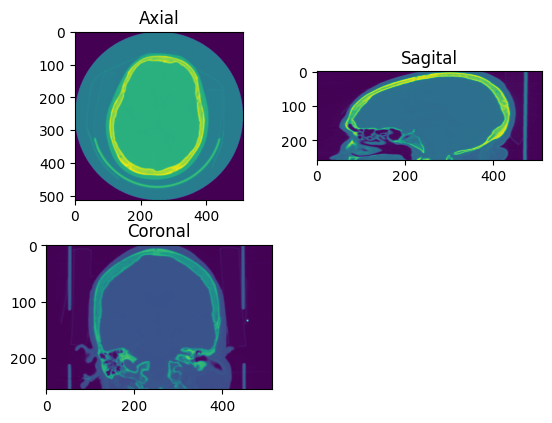

In [50]:
# plotando partes dos exames para garantir as visualizações em cortes
# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)
a1.title.set_text('Axial')

a2 = plt.subplot(2, 2, 2)
angle = 90
new_data = ndimage.rotate(img3d[:, img_shape[1]//2, :], angle, reshape=True)
plt.imshow(new_data)
a2.set_aspect(sag_aspect)
a2.title.set_text('Sagital')

a3 = plt.subplot(2, 2, 3)

new_data = ndimage.rotate(img3d[img_shape[0]//2, :, :], angle, reshape=True)
plt.imshow(new_data)
a3.set_aspect(cor_aspect)
a3.title.set_text('Coronal')

plt.show()

In [33]:
img3d.shape

(512, 512, 256)

In [11]:
exame1.shape

(256, 512, 512)

In [12]:
print(ps)
print(ss)

[0.488281, 0.488281]
0.625000


# Histograma
## Na imagem abaixo é possível notar uma grande quantidade de ar, dado que na escala hounsfield o ar é representado pela intensidade -1000
## Nota-se também uma considerável quantidade da intensidade 0, que representa a água. Em seguida valore que podem representar gordura e ossos

In [13]:
def plotarHistograma(exame):
    # plt.hist(exame.flatten(), bins=80, color='c')
    plt.hist(exame.flatten(), color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

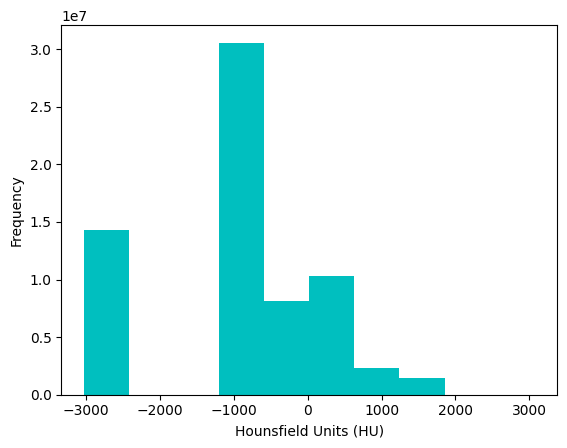

In [14]:
plotarHistograma(exame1)

# Plotar Slice
Após plotar um slice qualquer, plotar o gráfico de superfície para mostrar a irregularidade das imagens de tomografia

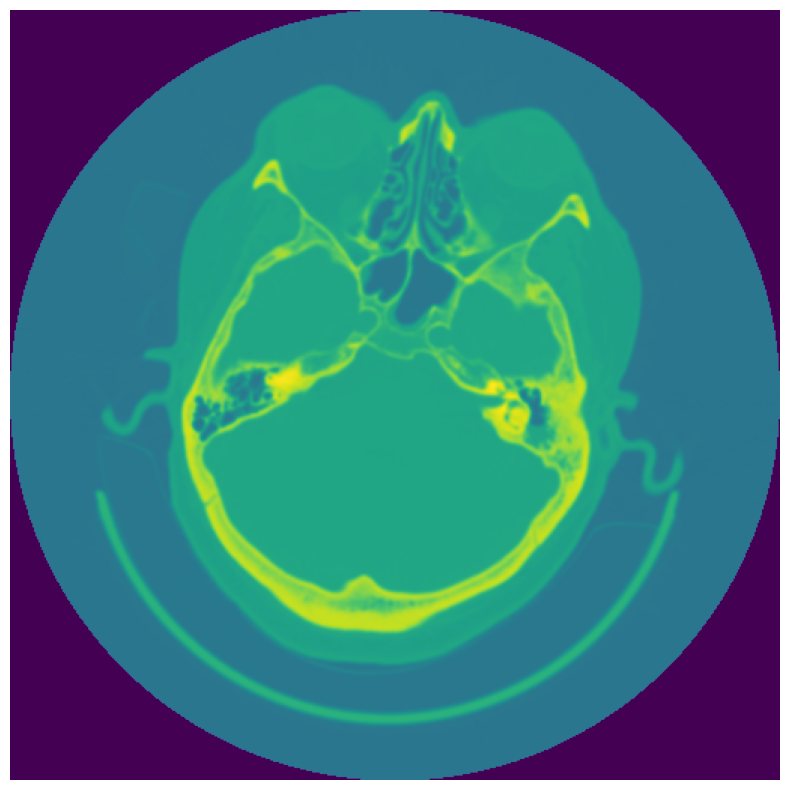

__main__:11: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



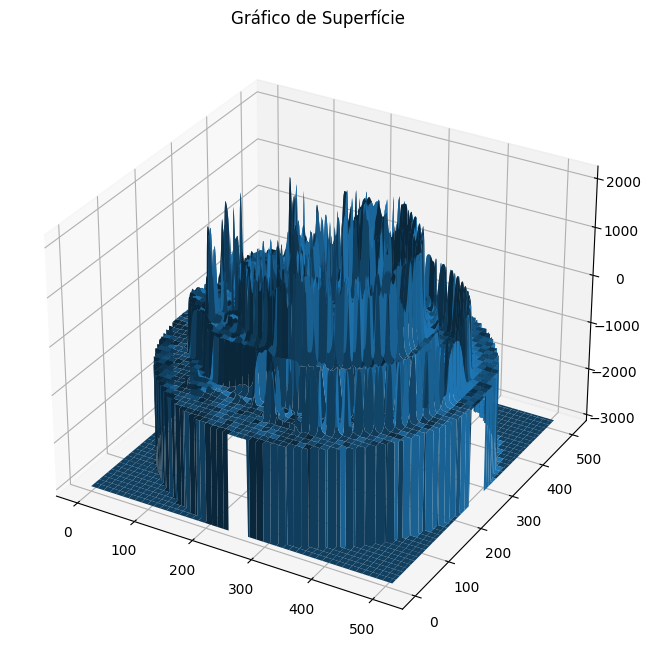

In [15]:
imagem = exame[64,:,:]

fig = plt.figure(figsize=(10,10))
plt.imshow(imagem)
plt.axis('off')
plt.show()

#plot 3d surface of the image. Help to undestand the aspect of the activation parameter
xx, yy = np.mgrid[0:imagem.shape[0], 0:imagem.shape[1]]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.set_title('Gráfico de Superfície')
ax.plot_surface(xx, yy, imagem )

# Superfície de uma imagem segmentada

In [16]:
imagem_segmentada =  cv2.imread(r'C:\Users\paulo\OneDrive\Imagens\segmentado.png')

In [17]:
imagem_segmentada = imagem_segmentada[:,:,2]
imagem_segmentada.shape

(594, 594)

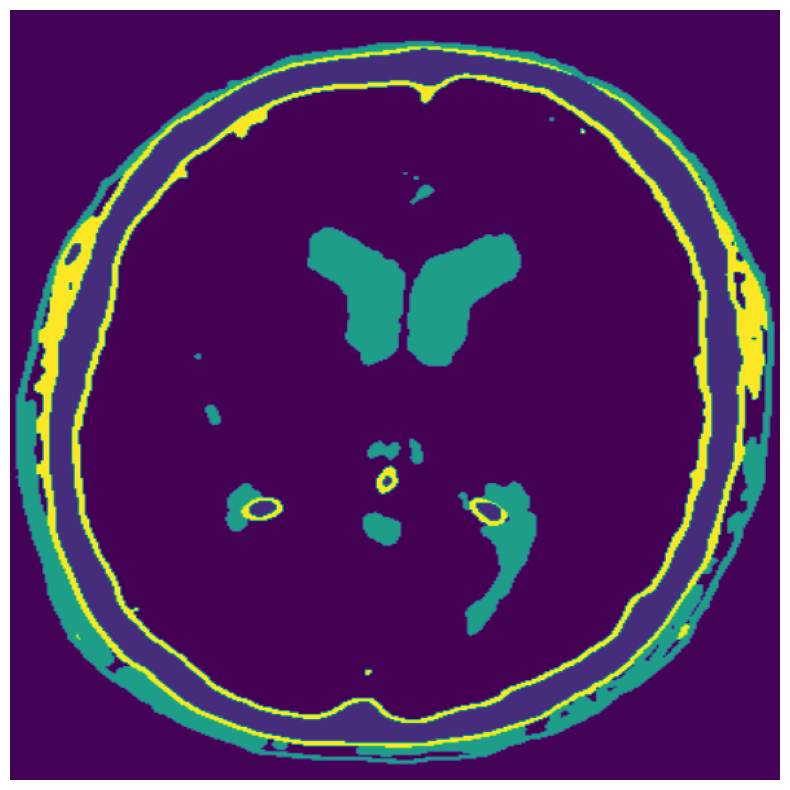

__main__:9: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



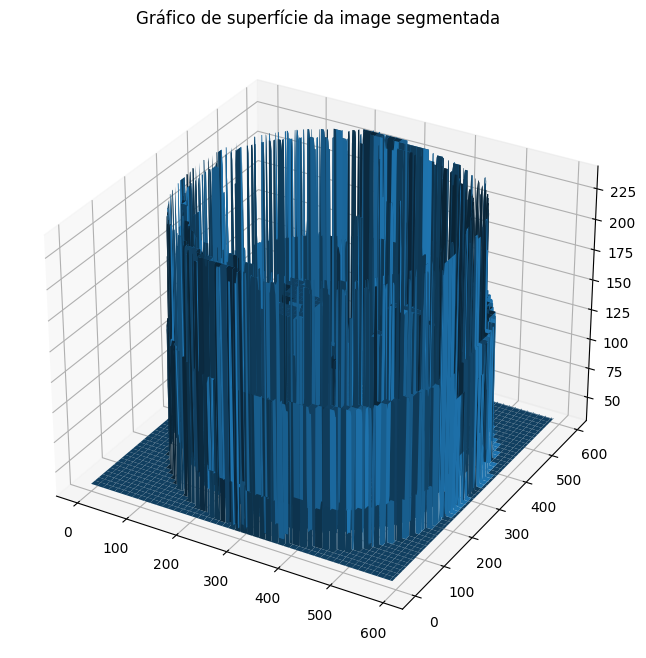

In [18]:

fig = plt.figure(figsize=(10,10))
plt.imshow(imagem_segmentada)
plt.axis('off')
plt.show()

#plot 3d surface of the image. Help to undestand the aspect of the activation parameter
xx, yy = np.mgrid[0:imagem_segmentada.shape[0], 0:imagem_segmentada.shape[1]]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.set_title('Gráfico de superfície da image segmentada')
ax.plot_surface(xx, yy, imagem_segmentada )

É notável que o exame em questão possui maior quantidade de ar e em segundo lugar, água. Usar um limiar nessas condições também funcionará em condições mais extremas ou mais semelhantes?


# Visualizador de dicom nos planos axial, coronal e sagital

In [19]:
# pixel aspects, assuming all slices are the same
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

print(ax_aspect)
print(sag_aspect)
print(cor_aspect)

1.0
0.7812496
1.2800006553603356


In [54]:
# Create button values
# fazer visualizador baseado 
# https://pydicom.github.io/pydicom/dev/auto_examples/image_processing/reslice.html
select_class = ToggleButtons(
    options=['Axial', 'Sagital', 'Coronal'],
    description='Useless:',
    disabled=False,
    button_style='info',

)
# Create layer slider
select_layer = IntSlider(min=0, max=exame.shape[0] -1, description='Select Layer', continuous_update=False)

# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer}")
    


    #Use s to select the class

    if seg_class == 'Axial':
        img = exame[layer,:,:]
        m_s = exame[layer,:,:]
    elif seg_class == 'Sagital':
        img = exame[:,layer,:]
        m_s = exame[:,layer,:]
    elif seg_class == 'Coronal':
        img = exame[:,:,layer]
        m_s = exame[:,:,layer]
    else:
        img = exame[layer,:,:]
        m_s = exame[layer,:,:]



    fig = plt.figure(figsize=(10,10))

    fig.add_subplot(1, 3, 1)
    plt.imshow(exame[layer,:,:], cmap='gray')
    plt.axis('off')
    # showing image
    plt.title("Axial")

    angle = 180
    
    # Adds a subplot at the 2nd position
    fig.add_subplot(1, 3, 2)
    
    new_data = ndimage.rotate(exame[:,layer,:], angle, reshape=True)
    plt.imshow(new_data, cmap='gray')
    plt.axis('off')
    plt.title("Coronal")
    
    # Adds a subplot at the 2nd position
    fig.add_subplot(1, 3, 3)
    
   
    new_data = ndimage.rotate(exame[:,:,layer], angle, reshape=True)
    plt.imshow(new_data)
    
    plt.imshow(new_data, cmap='gray')
    plt.axis('off')
    plt.title("Sagital")
    

    plt.show()

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Useless:', options=('Axial', 'Sagital', …

# Exibição dos tensores criados para serem a saída inicial da deep learning

__main__:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



{(0, 0, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d8e1fd30>,
 (0, 0, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d8bc0518>,
 (0, 1, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d8bc0b38>,
 (0, 1, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d8bc0f60>,
 (0, 2, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d8bc0400>,
 (0, 2, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d88cdf60>,
 (0, 3, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d88cdbe0>,
 (0, 3, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d88cd780>,
 (0, 4, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d88cddd8>,
 (0, 4, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d88cde80>,
 (1, 0, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d8c525f8>,
 (1, 0, 4): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d8c52978>,
 (1, 1, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x293d8c520b8>,
 (1, 1, 4): 

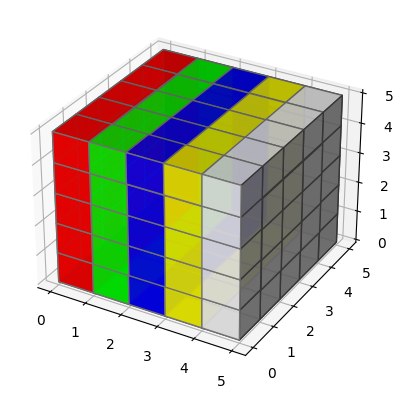

In [55]:
# Create axis
axes = [5, 5, 5]
 
# Create Data
data = np.ones(axes, dtype=np.bool)
 
# Control Transparency
alpha = 0.9
 
# Control colour
colors = np.empty(axes + [4], dtype=np.float32)
 
colors[0] = [1, 0, 0, alpha]  # red
colors[1] = [0, 1, 0, alpha]  # green
colors[2] = [0, 0, 1, alpha]  # blue
colors[3] = [1, 1, 0, alpha]  # yellow
colors[4] = [1, 1, 1, alpha]  # grey
 
# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
 
# Voxels is used to customizations of
# the sizes, positions and colors.
ax.voxels(data, facecolors=colors, edgecolors='grey')

# Arquitetura da cnn

a arquitetura, conforme explicado no artigo é a solução para uma das restrições do problema de otimização: semelhança de características. Ou seja, o processo de extração de características pela Cnn consegue atribuir os mesmos rótulos a pixels com características semelhantes.


In [56]:
# CNN model
class MyNet(nn.Module):
    def __init__(self, input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, args.nChannel, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(args.nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(args.nConv - 1):
            self.conv2.append(nn.Conv2d(args.nChannel, args.nChannel, kernel_size=3, stride=1, padding=1))
            self.bn2.append(nn.BatchNorm2d(args.nChannel))
        self.conv3 = nn.Conv2d(args.nChannel, args.nChannel, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(args.nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)

        for i in range(args.nConv - 1):
            x = self.conv2[i](x)
            x = F.relu(x)
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [57]:
# load image
# im = cv2.imread(args.input)
# data_old = torch.from_numpy(np.array([im.transpose((2, 0, 1)).astype('float32') / 255.]))

data = torch.from_numpy(np.array([exame1.astype('float32') / 255.]))
data.shape

torch.Size([1, 256, 512, 512])

In [ ]:
data

In [ ]:
# plotarHistograma(data)

In [ ]:
if use_cuda:
    data = data.cuda()
data = Variable(data)

In [ ]:
# train
# model = MyNet(data.size(1))

# instanciando a deep learning
# o parâmetro usado é referente a quantidade de canais de cores a serem processados
model = MyNet(1)
print(model)
if use_cuda:
    model.cuda()
model.train()

# Função de perda
## Entropia Cruzada
A função de perda de entropia cruzada é comumente utilizado em algoritmos de inteligência artificial que realizam classificação de dados. O cálculo realizado refere-se a diferença entre duas distribuições de probabilidade, uma sendo a verdadeira e outra sendo a desejada. A entropia cruzada mede o número médio de bits necessários para identificar um evento.

A função de erro da entropia cruzada é uma alternativa ao erro quadrático médio, o vetor de saída representa uma distribuição de probabilidade indicando a distância entre a distribuição calculada para a distribuição desejada. A entropia cruzada permite que erros alterem seus pesos, mesmo sobre saturação, tornando sua utilização mais útil para objetivos como 0 e 1. 

# Carregar uma imagem do mnist, numeral 5 e comparar com outro númeral 5 do mnist



In [1]:
# comparando a loss da entropia cruzada com númerais parecidos do dataset mnist
from torchvision import datasets as dts
from torchvision.transforms import ToTensor 
traindt = dts.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)


Using downloaded and verified file: data\MNIST\raw\train-images-idx3-ubyte.gz
Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Using downloaded and verified file: data\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Using downloaded and verified file: data\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Using downloaded and verified file: data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Processing...
Done!


E:\PycharmProjects\Doutorado\venv\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Usando uma imagem do mnist na deep learning
## Neste momento será usado como filtro, para que seja possível verificar a saída do processamento

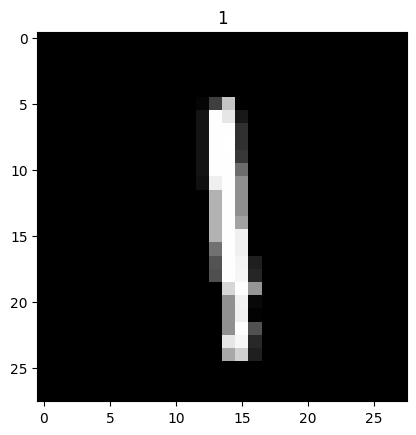

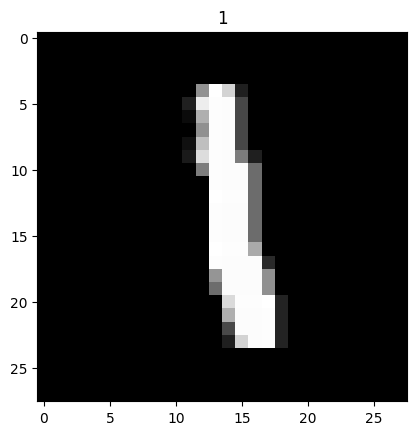

In [2]:
import matplotlib.pyplot as plot

plot.imshow(traindt.data[8], cmap='gray')
plot.title('%i' % traindt.targets[8])
plot.show()

plot.imshow(traindt.data[6], cmap='gray')
plot.title('%i' % traindt.targets[6])
plot.show()


In [21]:
loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# output = loss(input, target)
# output.backward()

#  # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()


output = Variable(traindt.data[6].float())
target = Variable(torch.FloatTensor(2).uniform_(0, 120).long())

output = loss(output, target)
print(output)

RuntimeError: 1D target tensor expected, multi-target not supported

In [18]:
numeral_hum = traindt.data[8]
numeral_hum = torch.from_numpy(np.array(numeral_hum ).astype('float32'))
numeral_hum = numeral_hum.reshape(1,1,28,28)
numeral_hum_saida = model(numeral_hum)[0]
numeral_hum_saida.shape

NameError: name 'model' is not defined

In [6]:
fig = plt.figure(figsize=(200, 200))
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

total = 100
col = 5
row = 20

for i in range(100):
    hum_saida = numeral_hum_saida[i, :, :]
    hum_saida = hum_saida.data.cpu().numpy()
    plt.subplot(row, col, i + 1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(hum_saida, cmap='gray')
    
    
#     ax = fig.add_subplot(row, col, i + 1)
#     ax.imshow(hum_saida, cmap='gray')
#     ax.text(0.5, 0.5, str((2, 3, i + 1)), fontsize=18, ha='center')

plot.show()
# for slice in range(100):
#     hum_saida = numeral_hum_saida[slice, :, :]
#     hum_saida = hum_saida.data.cpu().numpy()
#     plot.imshow(hum_saida, cmap='gray')
#     plot.show()
        

NameError: name 'numeral_hum_saida' is not defined

<Figure size 20000x20000 with 0 Axes>

In [7]:
# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()
# usando o erro quadrático médio para comparar com a entropia cruzada
loss_mse = torch.nn.MSELoss()
# convertendo os pixels do númeral hum em pontos flutuantes
real = torch.tensor(traindt.data[8], dtype=torch.float32)
desejado = torch.tensor(traindt.data[6], dtype=torch.float32)

#usando a entropia cruzada para mensurar a distância entre o numeral hum inicial com outro numeral um final
print(loss_fn(real,desejado))
print(loss_mse(real,desejado))


# testando a função de perda com escalares parecidos
real_2 = torch.from_numpy(np.array([2,2]).astype('float32'))
desejado_2 = torch.from_numpy(np.array([2,2]).astype('float32'))
print(loss_fn(real_2,desejado_2))
print(loss_mse(real_2,desejado_2))

E:\PycharmProjects\Doutorado\venv\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

E:\PycharmProjects\Doutorado\venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



RuntimeError: 1D target tensor expected, multi-target not supported

In [ ]:
# scribble loss definition
# usando a metodologia original do paper, a scribble loss foi retirada
# a mesma não faz sentido, por ora, para a utilização em tomografias de crânio
# loss_fn_scr = torch.nn.CrossEntropyLoss()


# continuity loss definition
# Creates a criterion that measures the mean absolute error (MAE) between each element in the input xx and target yy.
# Função que obtém a diferença de valor absoluto média por elemento.
loss_hpy = torch.nn.L1Loss(size_average=True)
loss_hpz = torch.nn.L1Loss(size_average=True)
# usando a função de perda para verificar as distâncias entre valores conhecidos
print(loss_hpy(real,desejado))
print(loss_hpy(real_2,desejado_2))

In [ ]:
# criando objetivos, ou seja, criando tensores compostos de zeros
# esses tensores serão utilizados como objetivos para poder reduzir os valores de perda no treinamento 
# não supervisionado das redes neurais
HPy_target = torch.zeros(512 - 1, 512, args.nChannel)
HPz_target = torch.zeros(512, 512 - 1, args.nChannel)

In [ ]:
HPy_target.shape

In [ ]:
HPy_target_low = torch.ones(5 - 1, 5, args.nChannel)
HPz_target_low = torch.ones(5, 5 - 1, args.nChannel)

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Voxels is used to customizations of
# the sizes, positions and colors.
ax.voxels(HPy_target_low.data.cpu().numpy(),  edgecolors='green')
plt.show()


# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(HPz_target_low.data.cpu().numpy(),  edgecolors='red')
plt.show()

In [ ]:
if use_cuda:
    HPy_target = HPy_target.cuda()
    HPz_target = HPz_target.cuda()

In [ ]:
# instanciando o algoritmo de gradiente descendente
# com parâmetros de learning rate e momentum
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)


In [ ]:

# comentado e trocado a escala de cores para tons de cinza, dado que as imagens de tomografia são preto e branco
# label_colours = np.random.randint(255, size=(100, 3))
# será criado um vetor de 100 posições, e para cada posição do vetor um número inteiro será sorteado de 0 até 255
# formando uma paleta de cores aleatórias
# será utilizado na visualização da imagem reconstruída e segmentada
label_colours = np.random.randint(255, size=(100, 1))

label_colours

# Demonstrando transformações realizadas no treinamento não supervisionado da rede
A permutação é uma transformação de translação, esta operação pode mudar o aspecto da informação. 
Suponha um tensor de dimensão 3, 5, 2. Onde o primeiro valor corresponde a quantidade de matrizes do tensor, o segundo valor corresponder de linhas da matriz e o último valor representa a quantidade de colunas de cada matriz do tensor.
A translação remodela o tensor, iniciando do índice zero até a quantidade de dimensões do tensor menos um. Ou seja, no caso do tensor supracitado ele terá os índices 0, 1, 2. E para remodelar o formato do tensor, basta realocar os índices.
Por exemplo:

torch.randn(3, 5, 2)

tensor([[[ 0.9790, -0.7450],
         [-0.8974, -0.8789],
         [-0.8061,  1.5718],
         [ 0.3964, -0.7514],
         [-0.0164,  0.1889]],

        [[ 0.3488, -0.3152],
         [ 1.4464,  1.5419],
         [ 1.1434, -0.8213],
         [ 0.5046, -1.5665],
         [ 0.3676,  1.5999]],

        [[-0.4622,  0.5683],
         [ 2.2810,  0.3738],
         [-1.0832, -1.2693],
         [-0.8423,  0.4644],
         [ 0.1536, -1.5017]]])
         
         
torch.permute(A, (1, 0, 2))

tensor([[[ 0.9790, -0.7450],
         [ 0.3488, -0.3152],
         [-0.4622,  0.5683]],

        [[-0.8974, -0.8789],
         [ 1.4464,  1.5419],
         [ 2.2810,  0.3738]],

        [[-0.8061,  1.5718],
         [ 1.1434, -0.8213],
         [-1.0832, -1.2693]],

        [[ 0.3964, -0.7514],
         [ 0.5046, -1.5665],
         [-0.8423,  0.4644]],

        [[-0.0164,  0.1889],
         [ 0.3676,  1.5999],
         [ 0.1536, -1.5017]]])
         
O tensor inicial tinha as dimensões de 3, 5, 2 e após a permutação 5, 3, 2. Pois os índices 0 e 1 sofreram alterção para 1 e 0.
As primeiras linhas de cada matriz, agora irão compor a primeira matriz da permutação. As segundas linhas de cada matriz irão corresponder a segunda matriz do novo tensor transladado e assim sucessivamente.

Há também uma transformação de visualização capaz de transformar um tensor n-dimensional em matriz bidimensional ou vetor unidimensional. Facilitando assim a visualização dos dados e possíveis novas transformações.

torch.permute(A, (1, 0, 2)).contiguous().view(-1,30)

tensor([[ 0.9790, -0.7450,  0.3488, -0.3152, -0.4622,  0.5683, -0.8974, -0.8789,
          1.4464,  1.5419,  2.2810,  0.3738, -0.8061,  1.5718,  1.1434, -0.8213,
         -1.0832, -1.2693,  0.3964, -0.7514,  0.5046, -1.5665, -0.8423,  0.4644,
         -0.0164,  0.1889,  0.3676,  1.5999,  0.1536, -1.5017]])
         
No exemplo acima, o primeiro parâmetro representa a quantidade de matrizes que o novo tensor deverá ter, enquanto que o segundo parâmetro representa a quantidade de itens presente em cada matriz do novo tensor. Os valores -1 e 30 representam um únivo vetor com trinta elementos.


In [ ]:
A = torch.randn(3, 5, 2)
A.size()
# output = torch.permute(A, (1, 0, 2)).contiguous().view(-1, 30)
# output = torch.permute(A, (1, 0, 2))
# print(output.size())
# print(output)

In [ ]:
A

In [ ]:
output

In [ ]:
output = torch.permute(A, (1, 0, 2)).contiguous().view(-1,15)
output

In [ ]:
# explicar o processo de permutação e o processo de view, usar uma tomografia
tensor_permuta = torch.randint(1, 10, (2,5,5))
tensor_permuta

In [ ]:
tensor_permuta_2 = tensor_permuta.permute(1, 2, 0).contiguous().view(-1, 10)
tensor_permuta_2

In [ ]:
tensor_permuta_2.shape

# Normalizar as imagens de entrada para a CNN entre [0,1]

# Plotar o gráfico que mostra as subidas e descidas da deeplearning, processo de otimização.

### Para cada iteração definida no início do código
### Para cada imagem 2d contida na tomografia, no aspecto axial
### Transformar a imagem que está no formato numpy array para tensor com formato (1,1,512,512) de pontos flutuantes (float32)
### Zerar o gradiente do otimizador, SGD
### submeter a imagem 2d no plano axial para o modelo, que irá retornar 100 imagens convoluídas (100,512,512)
### Após a transformação, será gerado uma matrix de dimensões (262144,100), ou seja, a junção de todas as imagens retornasdas pela rede
#### Plotar as imagens
### A imagem será remoldada para a dimensão (512,512,100)
### Uma nova imagem será criada com base na imagem anterior com as dimensões (511,512,100)
### Uma nova imagem será criada com base na imagem anterior com as dimensões (512,511,100)
### As duas imagens criadas serão submetidas para o cálculo do erro (explicar as funções de erro criadas)
### A imagem transformada de dimensão (262144,100) será submetida para função de máximo, onde será retornado um vetor de 262144. Ou seja, das 100 imagens, apenas uma de 512x512 com os picos máximos será mantido

In [ ]:
# importação de bibliotecas para visualização do resultado enquanto a rede estiver em treinamento
import time
import pylab as pl
from IPython import display

# quantidade de vezes que a deep learning será treinada
for batch_idx in range(args.maxIter):
    # a deep learning será treinada utilizando cada imagem, slice, fatia existente no exame
    for slice in range(256):
        data1 = exame1[slice, :, :]
        # transformando o slice em uma matrix numpy de floats
        data = torch.from_numpy(data1.reshape(1,1,512,512).astype('float32'))


        # forwarding zerando o gradiente para iniciar a otimização
        optimizer.zero_grad()
        # submetendo a imagem na deep learning e recebendo o retorno do processamento
        # neste momento a deep learning retorna 
        output1 = model(data)[0]
        # explicar o processo de permutação e o processo de view, usar uma tomografia
        output = output1.permute(1, 2, 0).contiguous().view(-1, args.nChannel)

        # plt.imshow(output.data.cpu().numpy())
        # plt.show()

        outputHP = output.reshape((data.shape[2], data.shape[3], args.nChannel))
        HPy = outputHP[1:, :, :] - outputHP[0:-1, :, :]
        HPz = outputHP[:, 1:, :] - outputHP[:, 0:-1, :]
        lhpy = loss_hpy(HPy, HPy_target)
        lhpz = loss_hpz(HPz, HPz_target)

        ignore, target = torch.max(output, 1)
        im_target = target.data.cpu().numpy()

        # plt.imshow(im_target.reshape(191, 194))
        # plt.show()

        nLabels = len(np.unique(im_target))

        if args.visualize:
            im_target_rgb = np.array([label_colours[c % args.nChannel] for c in im_target])
            im_target_rgb = im_target_rgb.reshape(512,512).astype(np.uint8)
            im_target_rgb = cv2.resize(im_target_rgb, (600, 600))
            data2 = cv2.resize(data1, (600, 600))
#             plt.imshow(im_target_rgb)
#             plt.imshow(data2)
            
            pl.clf()
            plt.imshow(im_target_rgb)
            display.display(pl.gcf())
            display.clear_output(wait=True)

#             cv2.imshow("output", im_target_rgb)
#             cv2.imshow("original", data2)
#             cv2.waitKey(0)
#             cv2.destroyWindow('output')
#             cv2.destroyWindow('original')
            
 

        # loss
        if args.scribble:
            loss = args.stepsize_sim * loss_fn(output[inds_sim], target[inds_sim]) + args.stepsize_scr * loss_fn_scr(
                output[inds_scr], target_scr[inds_scr]) + args.stepsize_con * (lhpy + lhpz)
        else:
            loss = args.stepsize_sim * loss_fn(output, target) + args.stepsize_con * (lhpy + lhpz)

        loss.backward()
        optimizer.step()

        torch.save(model.state_dict(), 'results/model.pth')
        torch.save(optimizer.state_dict(), 'results/optimizer.pth')

        print(batch_idx, '/', args.maxIter, '|', ' label num :', nLabels, ' | loss :', loss.item())

        if nLabels <= args.minLabels:
            print("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
            break


# Salvar um nifti
verificar o nifti no 3d slicer


# Criar uma camada densa ou uma camada inteligente para fazer a loss de continuidade


# outro exemplo de permutação para a tese
05/11/2022

In [16]:
a = torch.randn(2, 3, 4)


In [17]:
a

tensor([[[-1.7872,  0.1316, -0.8408, -1.0083],
         [ 2.3570,  1.3677,  0.3449,  0.3241],
         [ 0.3122,  0.9390,  1.5273, -0.2647]],

        [[-1.2692,  0.3952, -1.5439,  0.9820],
         [-0.9603,  0.7267, -0.2874, -1.1066],
         [-1.1911,  1.9282,  1.1305,  0.1571]]])

In [18]:
a.permute(1, 0, 2)

tensor([[[-1.7872,  0.1316, -0.8408, -1.0083],
         [-1.2692,  0.3952, -1.5439,  0.9820]],

        [[ 2.3570,  1.3677,  0.3449,  0.3241],
         [-0.9603,  0.7267, -0.2874, -1.1066]],

        [[ 0.3122,  0.9390,  1.5273, -0.2647],
         [-1.1911,  1.9282,  1.1305,  0.1571]]])

In [28]:
a.contiguous().view(-1,4)

tensor([[-1.7872,  0.1316, -0.8408, -1.0083],
        [ 2.3570,  1.3677,  0.3449,  0.3241],
        [ 0.3122,  0.9390,  1.5273, -0.2647],
        [-1.2692,  0.3952, -1.5439,  0.9820],
        [-0.9603,  0.7267, -0.2874, -1.1066],
        [-1.1911,  1.9282,  1.1305,  0.1571]])

In [3]:
p = torch.tensor([[-1.7872,  0.1316, -0.8408, -1.0083],
        [ 2.3570,  1.3677,  0.3449,  0.3241],
        [ 0.3122,  0.9390,  1.5273, -0.2647],
        [-1.2692,  0.3952, -1.5439,  0.9820],
        [-0.9603,  0.7267, -0.2874, -1.1066],
        [-1.1911,  1.9282,  1.1305,  0.1571]])

In [4]:
p

tensor([[-1.7872,  0.1316, -0.8408, -1.0083],
        [ 2.3570,  1.3677,  0.3449,  0.3241],
        [ 0.3122,  0.9390,  1.5273, -0.2647],
        [-1.2692,  0.3952, -1.5439,  0.9820],
        [-0.9603,  0.7267, -0.2874, -1.1066],
        [-1.1911,  1.9282,  1.1305,  0.1571]])

In [14]:
ignore, target = torch.max(p,1)
# p.max(1)

torch.return_types.max(
values=tensor([0.1316, 2.3570, 1.5273, 0.9820, 0.7267, 1.9282]),
indices=tensor([1, 0, 2, 3, 1, 1]))

In [13]:
ignore

tensor([0.1316, 2.3570, 1.5273, 0.9820, 0.7267, 1.9282])